In [1]:
from musetools import io as io
import matplotlib.pyplot as plt
from musetools import spec as s
import numpy as np
import getpass
from astropy.convolution import Gaussian2DKernel, convolve
from matplotlib import mlab, cm
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS
from importlib import reload
reload(io)

from copy import deepcopy

%matplotlib inline
username=getpass.getuser()

if username == 'bordoloi':
	fitsfile = '/Users/bordoloi/Dropbox/MUSE/LensedArc/RCS0327_16mc_zap.fits'
else:
	fitsfile = '/home/ahmed/astro/data/RCS0327_16mc_zap.fits'
#input("Enter the path to your file: ")


wave, data, var, header = io.open_muse_cube(fitsfile)

w = WCS(header)
header['CRVAL1'] = header['CRVAL1'] - 0.0001925000000042587
header['CRVAL2'] = header['CRVAL2'] - 0.0008772199999995678
#print(w)
print( 3600*proj_plane_pixel_scales(w))
wcs = WCS(header).celestial

[2.0e-01 2.0e-01 3.6e+03]


CIII Emission Map:

In [95]:
def residual(wave,data,minw,maxw,contmin,contmax):
    ems_image = io.narrow_band(minw,maxw,wave,data)
    cont_image = io.narrow_band(contmin,contmax,wave,data)
    residual_image = ems_image - cont_image
    return ems_image, cont_image, residual_image

ems_image_c, cont_image_c, residual_image_c = residual(wave,data,5143.27,5164.51,5360.66,5381.9)

'''
minwave_c = 5143.27
maxwave_c = 5164.51
ems_image_c = io.narrow_band(minwave_c, maxwave_c, wave, data,plot=False)

cont_min_c = 5360.66
cont_max_c = 5381.9
cont_image_c = io.narrow_band(cont_min_c, cont_max_c, wave, data,plot=False)
residual_image_c = ems_image_c - cont_image_c
'''
###
#Reading the MgII Emission maps to overplot the contours
ems_mgi,cont_mgi,residual_mgi= residual(wave,data,7558.4,7563.7,7645.,7650.3)
'''
minwave_mg = 7558.4
maxwave_mg = 7563.7
ems_image_mg = io.narrow_band(minwave_mg, maxwave_mg, wave, data,plot=False)
cont_min = 7645.
cont_max = 7650.3
cont_image = io.narrow_band(cont_min_, cont_max, wave, data,plot=False)

residual_image=ems_image-cont_image
'''

'\nminwave_mg = 7558.4\nmaxwave_mg = 7563.7\nems_image_mg = io.narrow_band(minwave_mg, maxwave_mg, wave, data,plot=False)\ncont_min = 7645.\ncont_max = 7650.3\ncont_image = io.narrow_band(cont_min_, cont_max, wave, data,plot=False)\n\nresidual_image=ems_image-cont_image\n'

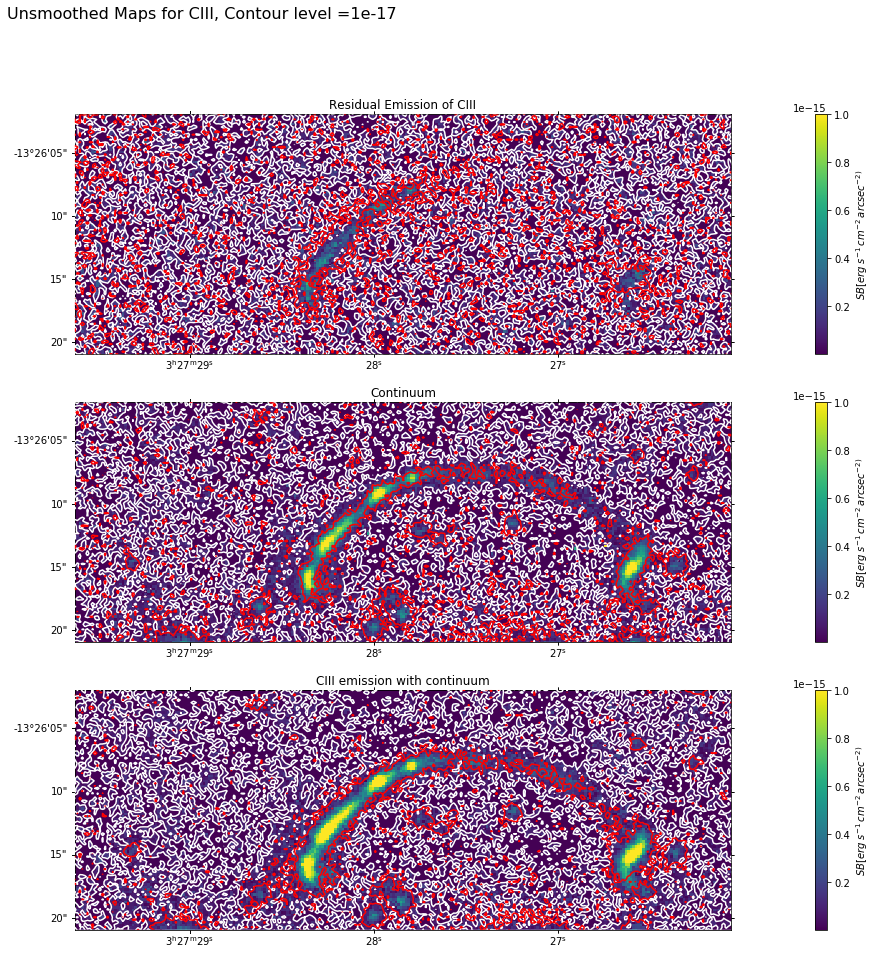

In [96]:

zmin=1e-18
zmax=1e-15
cont_level = [1e-17]
fig=plt.figure(1)
fig.suptitle('Unsmoothed Maps for CIII, Contour level ='+str(cont_level[0])+'',fontsize=16)


fig.set_figheight(15)
fig.set_figwidth(30)
ax = fig.add_subplot(311,projection=wcs)
im = ax.imshow( residual_image_c, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
CS = plt.contour(residual_image_c,levels=cont_level,colors='white')
CS1 = plt.contour(residual_mgi,levels=cont_level,colors='red')
#ax.clabel(CS,cont_level)
ax.set_title('Residual Emission of CIII')
ax.set_ylim([205,300])
ax.set_xlim([20,280])

ax2 = fig.add_subplot(312,projection=wcs)
im2 =ax2.imshow(cont_image_c , cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(cont_image_c,levels=cont_level,colors='white')
ax2.contour(cont_mgi,levels=cont_level,colors='red')
ax2.set_title('Continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])



ax3 = fig.add_subplot(313,projection=wcs)
im3 = ax3.imshow(ems_image_c, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(ems_image_c,levels=cont_level,colors='white')
ax3.contour(ems_mgi,levels=cont_level,colors='red')
ax3.set_title('CIII emission with continuum')
ax3.set_ylim([205,300])
ax3.set_xlim([20,280])
#fig.savefig('/home/ahmed/astro/figures/emission_maps/CIII_emissionmap_unsmooth.pdf')
plt.show()

In [10]:
def convolve_image(image,stdev=1.):
   # We smooth with a Gaussian kernel with stddev=2
   # It is a 9x9 array
   kernel = Gaussian2DKernel(x_stddev=stdev)
   # create a "fixed" image with NaNs replaced by interpolated values
   # astropy's convolution replaces the NaN pixels with a kernel-weighted
   # interpolation from their neighbors
   astropy_conv = convolve(image, kernel)
   mean_val=(np.mean(astropy_conv))
   std_val=(np.std(astropy_conv))
   sig_threshold=3.

   qq=np.where((astropy_conv < sig_threshold*std_val))
   qq_complement=np.where((astropy_conv >= sig_threshold*std_val))

   ROI=deepcopy(astropy_conv)
   ROI[qq]= 0.

   #Now create a mask

   Mask=deepcopy(astropy_conv)
   Mask[qq_complement]=1.
   Mask[qq]=0.

   final_image= astropy_conv*Mask

   return final_image,astropy_conv

q=np.isnan(residual_image_c)
residual_image_c[q]=0
mask = 0.*residual_image_c

print(mask[0,0])


mask[210:290,80:270] = 1.


0.0


/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


(80, 269)

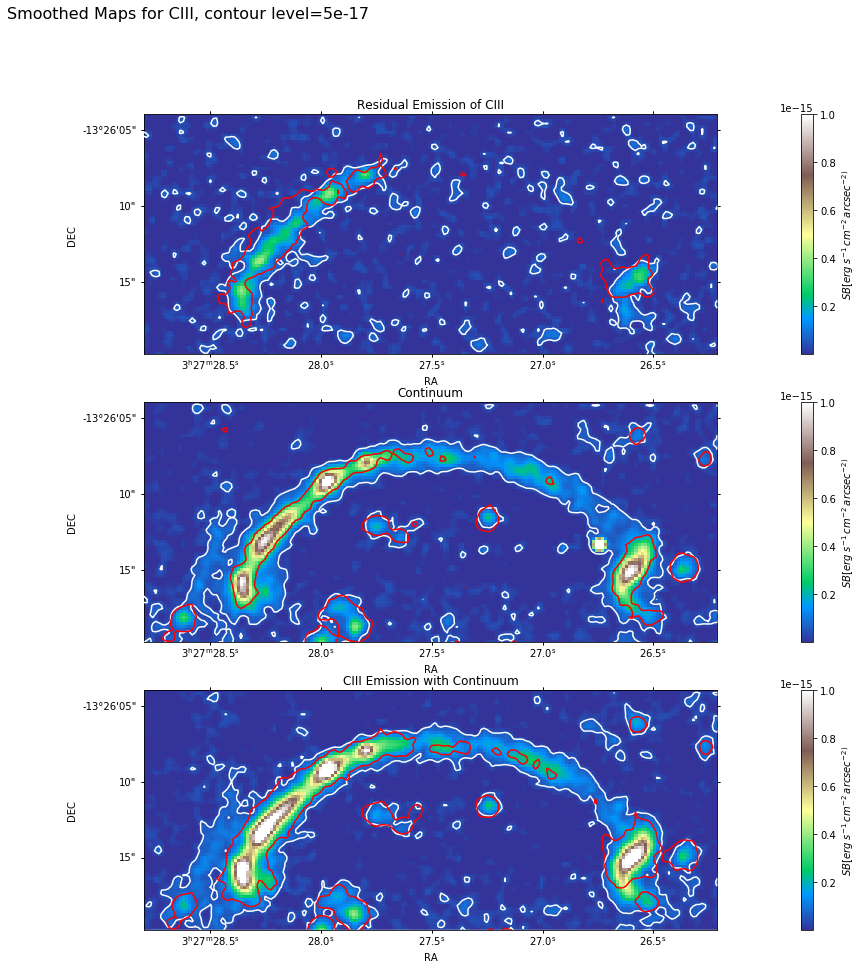

In [97]:
final_im_c,conv_im_c=convolve_image(residual_image_c)
final_cont_c,conv_cont_c = convolve_image(cont_image_c)
final_ems_c,conv_ems_c = convolve_image(ems_image_c)


final_im_mgi, conv_im_mgi = convolve_image(residual_mgi)
final_cont_mgi, conv_cont_mgi = convolve_image(cont_mgi)
final_ems_mgi, conv_ems_mgi = convolve_image(ems_mgi)


cont_level = [5e-17]
cont_level_mg = [1e-17]
fig = plt.figure()
fig.suptitle('Smoothed Maps for CIII, contour level='+str(cont_level[0])+'',fontsize=16)
fig.set_figheight(15)
fig.set_figwidth(30)
ax1 = plt.subplot(311, projection=wcs)
im = ax1.imshow(mask*conv_im_c, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
CS1 = plt.contour(mask*conv_im_c,levels=cont_level,colors='white')
CS2 = plt.contour(mask*conv_im_mgi,levels=cont_level_mg,colors='red')
#plt.clabel(CS1,cont_level,fmt=)
ax1.set_title('Residual Emission of CIII')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
#ax1.set_ylim([205,300])
#ax1.set_xlim([20,280])
ax1.set_ylim([211,290])
ax1.set_xlim([80,269])

ax2 = plt.subplot(312, projection=wcs)
im2 =ax2.imshow(mask*conv_cont_c , cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(mask*conv_cont_c,levels=cont_level,colors='white')
ax2.contour(mask*conv_cont_mgi,levels=cont_level_mg,colors='red')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
ax2.set_title('Continuum')
ax2.set_ylim([211,290])
ax2.set_xlim([80,269])

ax3 = plt.subplot(313, projection=wcs)
im3 = ax3.imshow(mask*conv_ems_c, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(mask*conv_ems_c,levels=cont_level,colors='white')
ax3.contour(mask*conv_ems_mgi,levels=cont_level_mg,colors='red')
ax3.set_title('CIII Emission with Continuum')
ax3.set_xlabel('RA')
ax3.set_ylabel('DEC')
ax3.set_ylim([211,290])
ax3.set_xlim([80,269])
#fig.savefig('/home/ahmed/astro/figures/emission_maps/CIII_emissionmap_smooth_RA_DEC.pdf')

For the OII Emission maps:

In [99]:
minwave_o = 6670.21
maxwave_o = 6684.02
ems_image_o = io.narrow_band(minwave_o, maxwave_o, wave, data,plot=False)

cont_min_o = 6744.44
cont_max_o = 6758.25
cont_image_o = io.narrow_band(cont_min_o, cont_max_o, wave, data,plot=False)


residual_image_o = ems_image_o - cont_image_o

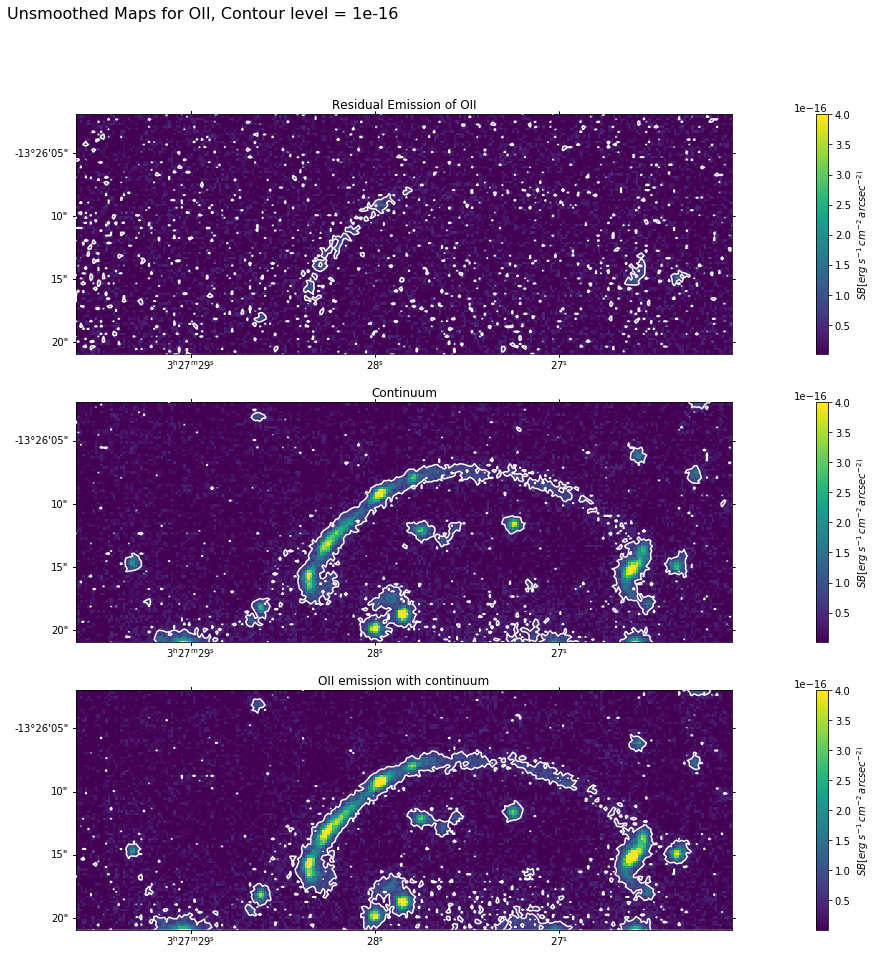

In [100]:

zmin=1e-18
zmax=4e-16
cont_level = [0.5e-16]
fig=plt.figure(1)
fig.suptitle('Unsmoothed Maps for OII, Contour level = 1e-16',fontsize=16)


fig.set_figheight(15)
fig.set_figwidth(30)
ax = fig.add_subplot(311,projection=wcs)
im = ax.imshow( residual_image_o, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
CS = plt.contour(residual_image_o,levels=cont_level,colors='white')
#ax.clabel(CS,cont_level)
ax.set_title('Residual Emission of OII')
ax.set_ylim([205,300])
ax.set_xlim([20,280])

ax2 = fig.add_subplot(312,projection=wcs)
im2 =ax2.imshow(cont_image_o , cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(cont_image_o,levels=cont_level,colors='white')
ax2.set_title('Continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])



ax3 = fig.add_subplot(313,projection=wcs)
im3 = ax3.imshow(ems_image_o, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(ems_image_o,levels=cont_level,colors='white')
ax3.set_title('OII emission with continuum')
ax3.set_ylim([205,300])
ax3.set_xlim([20,280])
fig.savefig('/home/ahmed/astro/figures/emission_maps/OII_emissionmap_unsmooth_17.pdf')
plt.show()

/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


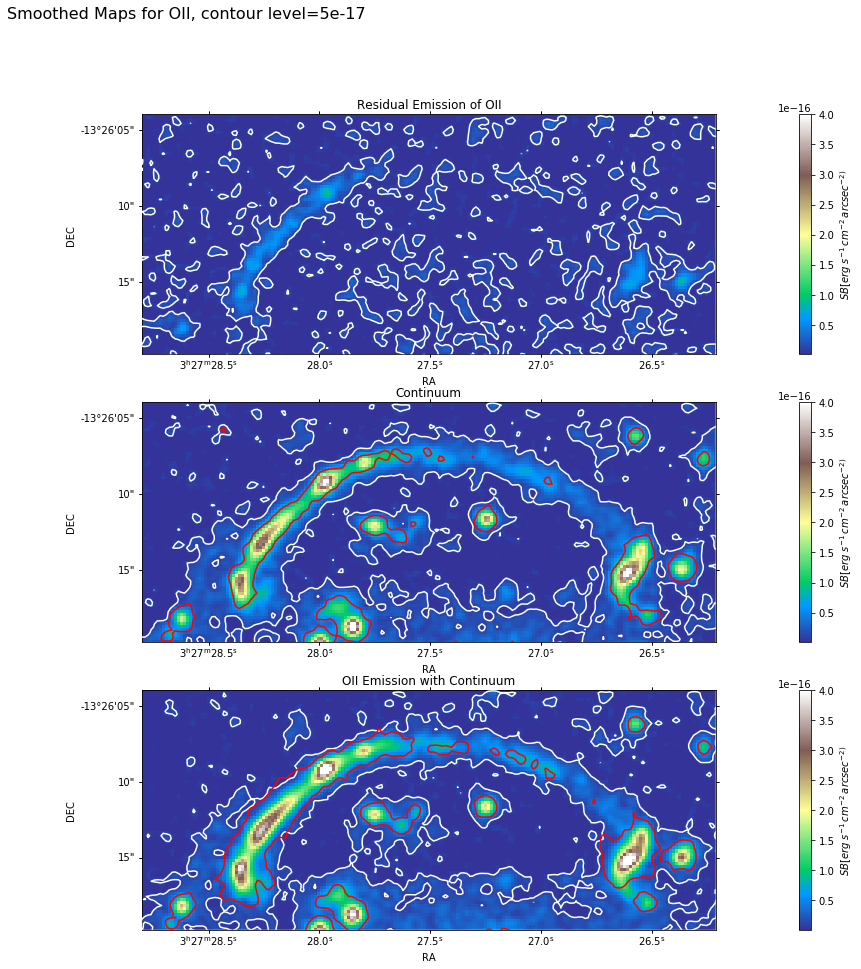

In [101]:
final_im_o,conv_im_o=convolve_image(residual_image_o)
final_cont_o,conv_cont_o = convolve_image(cont_image_o)
final_ems_o,conv_ems_o = convolve_image(ems_image_o)

cont_level = [0.1e-16]

fig = plt.figure()
fig.suptitle('Smoothed Maps for OII, contour level=5e-17',fontsize=16)
fig.set_figheight(15)
fig.set_figwidth(30)
ax1 = plt.subplot(311, projection=wcs)
im = ax1.imshow(mask*conv_im_o, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
CS1 = plt.contour(mask*conv_im_o,levels=cont_level,colors='white')
#plt.clabel(CS1,cont_level,fmt=)
ax1.set_title('Residual Emission of OII')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_ylim([211,290])
ax1.set_xlim([80,269])

ax2 = plt.subplot(312, projection=wcs)
im2 =ax2.imshow(mask*conv_cont_o , cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(mask*conv_cont_o,levels=cont_level,colors='white')
ax2.contour(mask*conv_cont_mgi,levels=cont_level_mg,colors='red')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
ax2.set_title('Continuum')
ax2.set_ylim([211,290])
ax2.set_xlim([80,269])

ax3 = plt.subplot(313, projection=wcs)
im3 = ax3.imshow(mask*conv_ems_o, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(mask*conv_ems_o,levels=cont_level,colors='white')
ax3.contour(mask*conv_ems_mgi,levels=cont_level_mg,colors='red')
ax3.set_title('OII Emission with Continuum')
ax3.set_xlabel('RA')
ax3.set_ylabel('DEC')
ax3.set_ylim([211,290])
ax3.set_xlim([80,269])
fig.savefig('/home/ahmed/astro/figures/emission_maps/OII_emissionmap_smooth_17_RA_DEC.pdf')

In [151]:
print(data.shape)
def multi_band(minwave, maxwave, wave, flux_data):
    '''
    minwave:   array of minimum wavelength of the narrow bands
    maxwave:   array of maximum wavelength of the narrow bands
    wave:      The wavelength interval from the data cube
    flux_data: The 2-D flux data from the data cube

    The output of this function is a wavelength narrow band image of the LensedArc
    '''
    q = []
    image=np.zeros((349,352,len(minwave)))
    
    for i in range(len(minwave)):
        factor = 10.**(-20.)*(maxwave[i]-minwave[i]) / (0.2)**2.
        q_i = np.where(( wave > minwave[i]) & (wave < maxwave[i]))# Defining the chosen wavelength interval
        image[:,:,i] = (np.sum(flux_data[q_i,:,:], axis = 1))*factor              # We now sum the wavelength within the given interval
    
    image_SB=np.mean(image,axis=2)

    return image_SB

(3802, 349, 352)


In [74]:
def residual_m(wave,data,minw,maxw,contmin,contmax):
    ems_image = io.narrow_band(minw,maxw,wave,data)
    cont_image = io.narrow_band(contmin,contmax,wave,data)
    residual_image = ems_image - cont_image
    return ems_image, cont_image, residual_image

In [147]:
minw_mg = [7558.4,7578.42]
maxw_mg = [7563.7,7612.11]
contmin_mg = [7645.,8106.34]
contmax_mg = [7650.3,8140.03]

ems_mg = multi_band(minw_mg,maxw_mg,wave,data)
cont_mg = multi_band(contmin_mg,contmax_mg,wave,data)
residual_mg = ems_mg-cont_mg
'''
ems_mg0, cont_mg0, residual_mg0 = residual_m(wave,data,minw[0],maxw[0],contmin[0],contmax[0])
ems_mg1, cont_mg1, residual_mg1 = residual_m(wave,data,minw[1],maxw[1],contmin[1],contmax[1])
ems_mg = ems_mg0 + ems_mg1
cont_mg = cont_mg0 + cont_mg1
residual_mg = residual_mg0 + residual_mg1
'''

'\nems_mg0, cont_mg0, residual_mg0 = residual_m(wave,data,minw[0],maxw[0],contmin[0],contmax[0])\nems_mg1, cont_mg1, residual_mg1 = residual_m(wave,data,minw[1],maxw[1],contmin[1],contmax[1])\nems_mg = ems_mg0 + ems_mg1\ncont_mg = cont_mg0 + cont_mg1\nresidual_mg = residual_mg0 + residual_mg1\n'

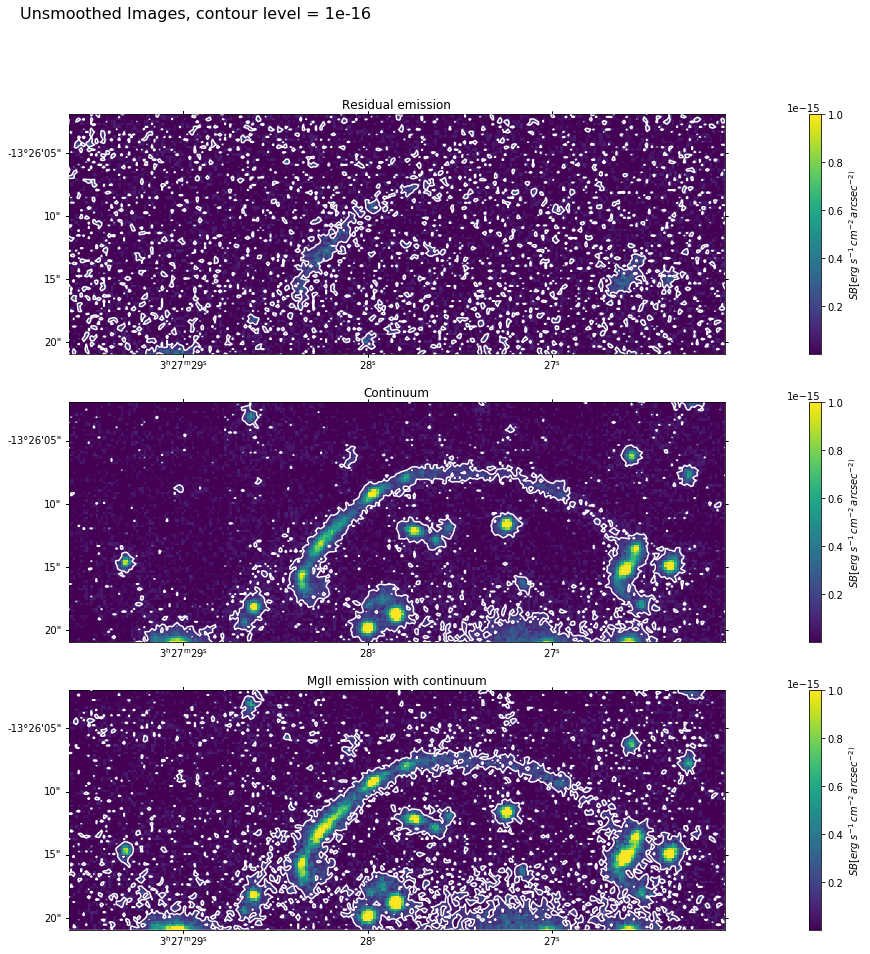

In [152]:
zmin=1e-18
zmax=1e-15

cont_level = [1e-16]
width_in = 10
fig=plt.figure(1)
fig.suptitle('Unsmoothed Images, contour level = '+str(cont_level[0])+'',fontsize=16)
ax = fig.add_subplot(311,projection=wcs)
#fig, ax = plt.subplots(3)
#width_in = 30
#fig.figsize=(width_in, 15)
fig.set_figheight(15)
fig.set_figwidth(30)
im = ax.imshow( residual_mg, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
ax.contour(residual_mg,levels=cont_level,colors='white')
ax.set_title('Residual emission')
ax.set_ylim([205,300])
ax.set_xlim([20,280])
'''
ax1 = fig.add_subplot(312)
ax1.imshow(np.log10(np.abs(residual_SB)), cmap = plt.get_cmap('viridis'), origin='lower', vmin =zmin, vmax = zmax)
ax1.set_title('Continuum')
ax1.set_ylim([205,300])
ax1.set_xlim([20,280])
'''
ax2 = fig.add_subplot(312,projection=wcs)
im2 =ax2.imshow(cont_mg , cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(cont_mg,levels=cont_level,colors='white')
ax2.set_title('Continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])



ax3 = fig.add_subplot(313,projection=wcs)
im3 = ax3.imshow(ems_mg, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(ems_mg,levels=cont_level,colors='white')
ax3.set_title('MgII emission with continuum')
ax3.set_ylim([205,300])
ax3.set_xlim([20,280])
#fig.savefig('/home/ahmed/astro/figures/emission_maps/MgII_emissionmap_unsmooth.pdf')
plt.show()


In [87]:
final_im_mg, conv_im_mg = convolve_image(residual_mg)
final_cont_mg, conv_cont_mg = convolve_image(cont_mg)
final_ems_mg, conv_ems_mg = convolve_image(ems_mg)

/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


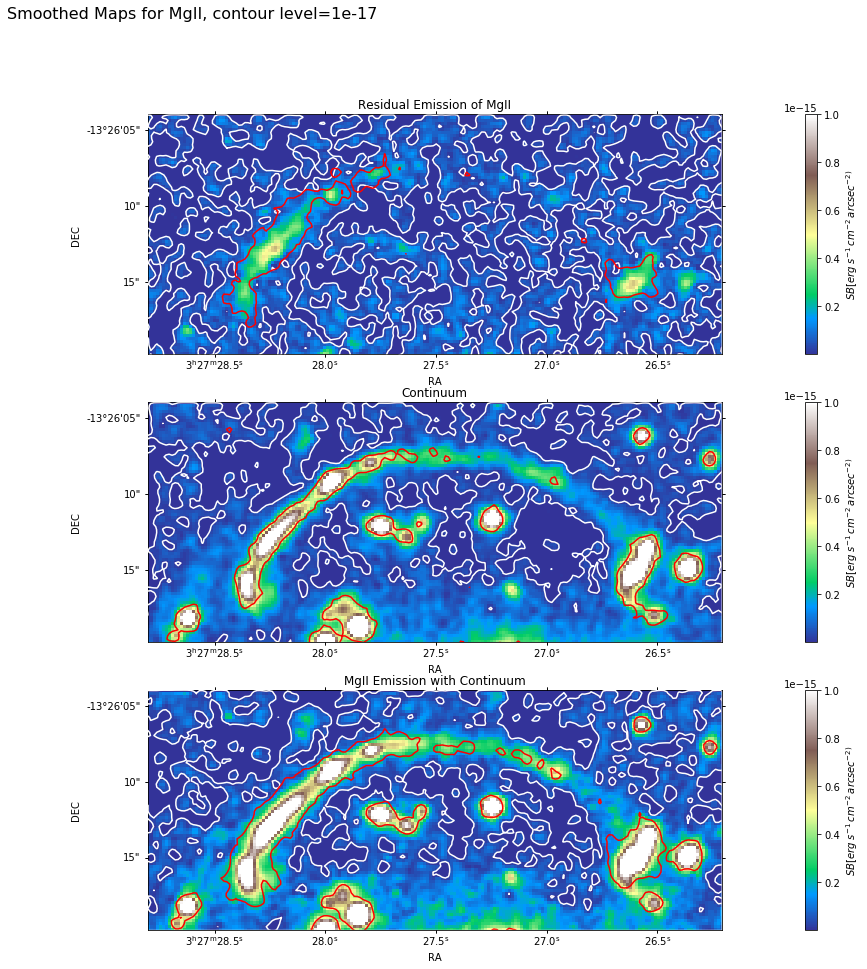

In [110]:
cont_level = [1e-17]

fig = plt.figure()
fig.suptitle('Smoothed Maps for MgII, contour level='+str(cont_level[0])+'',fontsize=16)
fig.set_figheight(15)
fig.set_figwidth(30)
ax1 = plt.subplot(311, projection=wcs)
im = ax1.imshow(mask*conv_im_mg, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
CS1 = plt.contour(mask*conv_im_mg,levels=cont_level,colors='white')
ax1.contour(mask*conv_im_mgi,levels=cont_level,colors='red')
ax1.set_title('Residual Emission of MgII')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_ylim([211,290])
ax1.set_xlim([80,269])

ax2 = plt.subplot(312, projection=wcs)
im2 =ax2.imshow(mask*conv_cont_mg , cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(mask*conv_cont_mg,levels=cont_level,colors='white')
ax2.contour(mask*conv_cont_mgi,levels=cont_level,colors='red')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
ax2.set_title('Continuum')
ax2.set_ylim([211,290])
ax2.set_xlim([80,269])

ax3 = plt.subplot(313, projection=wcs)
im3 = ax3.imshow(mask*conv_ems_mg, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(mask*conv_ems_mg,levels=cont_level,colors='white')
ax3.contour(mask*conv_ems_mgi,levels=cont_level,colors='red')
ax3.set_title('MgII Emission with Continuum')
ax3.set_xlabel('RA')
ax3.set_ylabel('DEC')
ax3.set_ylim([211,290])
ax3.set_xlim([80,269])
fig.savefig('/home/ahmed/astro/figures/emission_maps/MgII_tot_emissionmap_smooth_17_RA_DEC.pdf')

In [154]:
minw_fe = [7054.44, 7086.39]
maxw_fe = [7068.96, 7120.76]
contmin_fe = [7150.43, 7165.]
contmax_fe = [7164.95, 7199.37]

ems_fe = multi_band(minw_fe,maxw_fe, wave, data)
cont_fe = multi_band(contmin_fe, contmax_fe, wave, data)
residual_fe = ems_fe - cont_fe

For the FeII lines Emission Maps: 

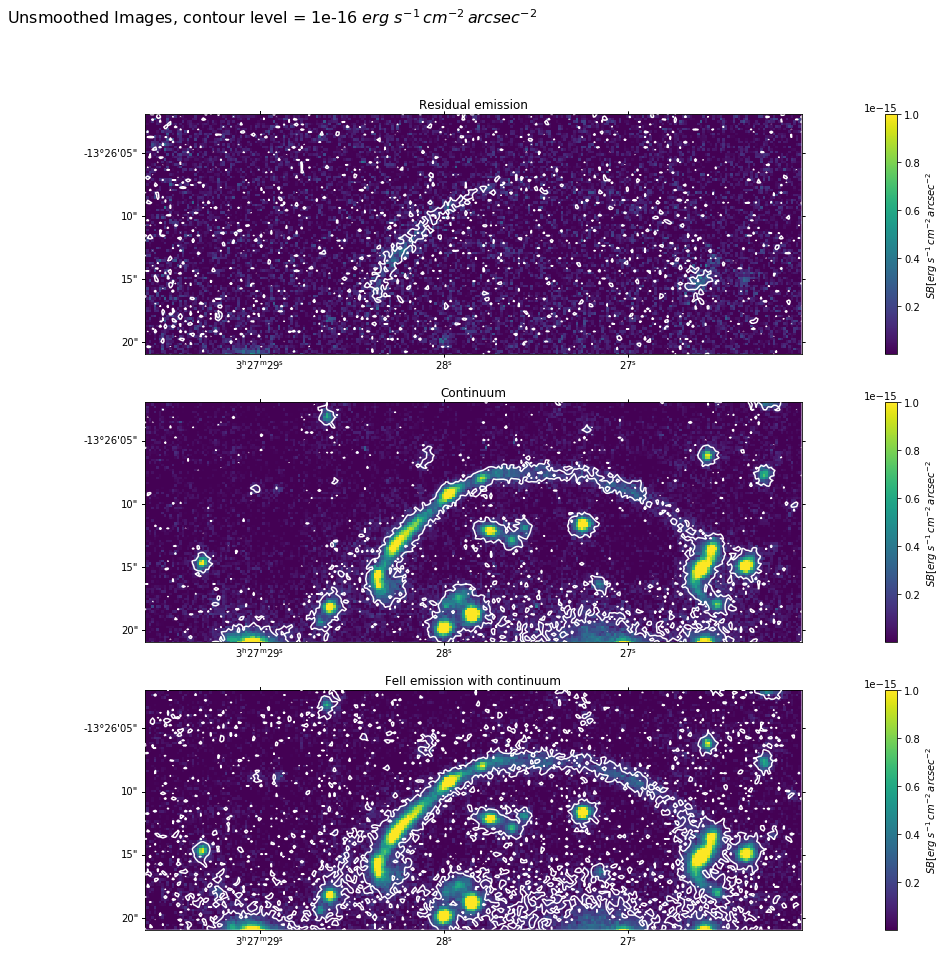

In [155]:
zmin=1e-18
zmax=1e-15

cont_level = [1e-16]
width_in = 10
fig=plt.figure(1)
fig.suptitle(r'Unsmoothed Images, contour level = '+str(cont_level[0])+' $erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2}$',fontsize=16)
ax = fig.add_subplot(311,projection=wcs)
#fig, ax = plt.subplots(3)
#width_in = 30
#fig.figsize=(width_in, 15)
fig.set_figheight(15)
fig.set_figwidth(30)
im = ax.imshow( residual_mg, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
ax.contour(residual_fe,levels=cont_level,colors='white')
ax.set_title('Residual emission')
ax.set_ylim([205,300])
ax.set_xlim([20,280])

ax2 = fig.add_subplot(312,projection=wcs)
im2 =ax2.imshow(cont_fe , cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2}$')
ax2.contour(cont_mg,levels=cont_level,colors='white')
ax2.set_title('Continuum')
ax2.set_ylim([205,300])
ax2.set_xlim([20,280])



ax3 = fig.add_subplot(313,projection=wcs)
im3 = ax3.imshow(ems_fe, cmap = plt.get_cmap('viridis'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2}$')
ax3.contour(ems_mg,levels=cont_level,colors='white')
ax3.set_title('FeII emission with continuum')
ax3.set_ylim([205,300])
ax3.set_xlim([20,280])
fig.savefig('/home/ahmed/astro/figures/emission_maps/FeII_emissionmap_unsmooth.pdf')
plt.show()


In [156]:
final_im_fe, conv_im_fe = convolve_image(residual_fe)
final_cont_fe, conv_cont_fe = convolve_image(cont_fe)
final_ems_fe, conv_ems_fe = convolve_image(ems_fe)

/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/home/ahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


/home/ahmed/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


(80, 269)

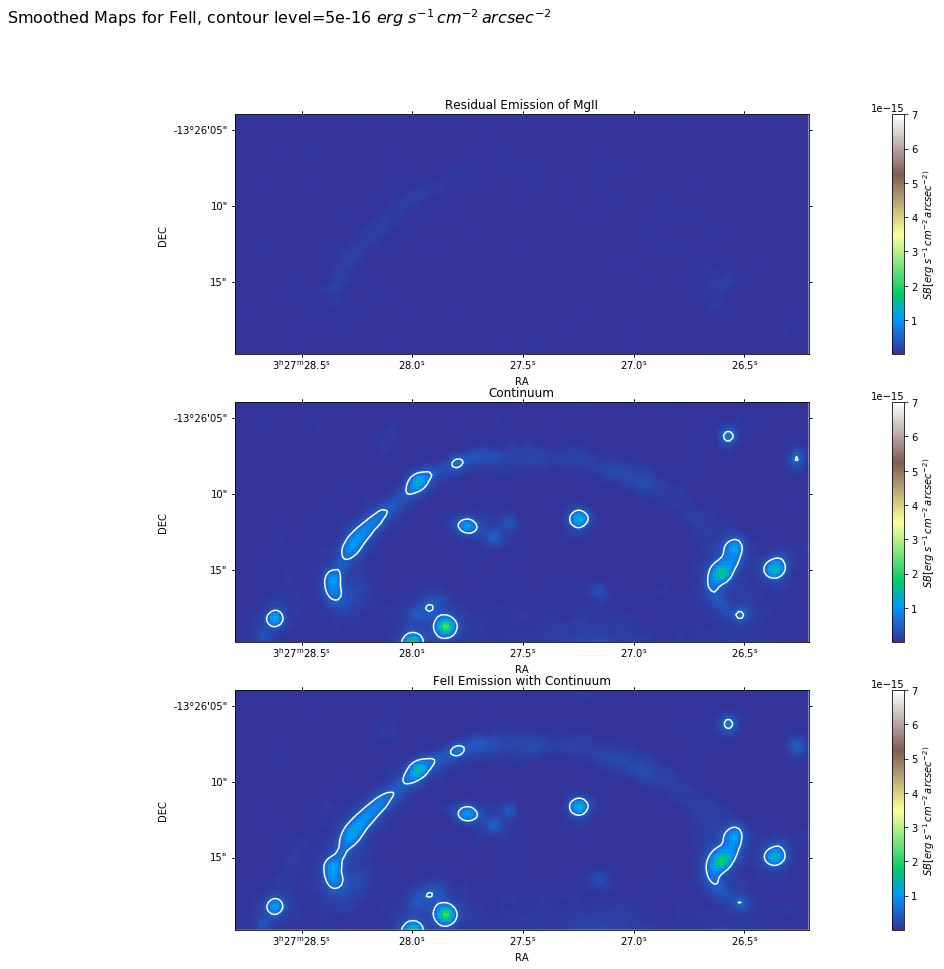

In [157]:
cont_level = [0.5e-15]
zmax = 7e-15

fig = plt.figure()
fig.suptitle('Smoothed Maps for FeII, contour level='+str(cont_level[0])+' $erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2}$',fontsize=16)
fig.set_figheight(15)
fig.set_figwidth(30)
ax1 = plt.subplot(311, projection=wcs)
im = ax1.imshow(mask*conv_im_fe, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
#ax.contour(ems_image-cont_image,levels=(1e-17,1e-16),colors='black')
CS1 = plt.contour(mask*conv_im_fe,levels=cont_level,colors='white')
#ax1.contour(mask*conv_im_mgi,levels=cont_level,colors='red')
ax1.set_title('Residual Emission of MgII')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_ylim([211,290])
ax1.set_xlim([80,269])

ax2 = plt.subplot(312, projection=wcs)
im2 =ax2.imshow(mask*conv_cont_fe , cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im2,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax2.contour(mask*conv_cont_fe,levels=cont_level,colors='white')
#ax2.contour(mask*conv_cont_mgi,levels=cont_level,colors='red')
ax2.set_xlabel('RA')
ax2.set_ylabel('DEC')
ax2.set_title('Continuum')
ax2.set_ylim([211,290])
ax2.set_xlim([80,269])

ax3 = plt.subplot(313, projection=wcs)
im3 = ax3.imshow(mask*conv_ems_fe, cmap = plt.get_cmap('terrain'), origin='lower',vmin=zmin, vmax=zmax)
fig.colorbar(im3,label =r'$SB[erg\/ \/s^{-1}\/cm^{-2} \/arcsec^{-2)}$')
ax3.contour(mask*conv_ems_fe,levels=cont_level,colors='white')
#ax3.contour(mask*conv_ems_mgi,levels=cont_level,colors='red')
ax3.set_title('FeII Emission with Continuum')
ax3.set_xlabel('RA')
ax3.set_ylabel('DEC')
ax3.set_ylim([211,290])
ax3.set_xlim([80,269])
#fig.savefig('/home/ahmed/astro/figures/emission_maps/MgII_tot_emissionmap_smooth_17_RA_DEC.pdf')